In [2]:
!https://github.com/PinzhengWang322/Reveal_Attention_Drift.git
!pip install datasets > install.log 2>&1
!pip install transformers==4.40.0 > install.log 2>&1

Cloning into 'Reveal_Attention_Drift'...
remote: Enumerating objects: 879, done.
remote: Counting objects: 100% (879/879), done.
remote: Compressing objects: 100% (662/662), done.
remote: Total 879 (delta 206), reused 876 (delta 203), pack-reused 0 (from 0)
Receiving objects: 100% (879/879), 6.48 MiB | 10.39 MiB/s, done.
Resolving deltas: 100% (206/206), done.


In [3]:
IS_COLAB = False
try:
    import google.colab, torch, os
    os.chdir("/content/Reveal_Attention_Drift/jupyter_notebook")
    IS_COLAB = True
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

# Attention Drift
![attention_drift](https://drive.google.com/uc?id=1gWsvut68-erLHysTPPOQSHFGlmVGaRuU)

A Demonstration of Attention Drift in Knowledge Editing

As shown in the figure above,  the edited model assigns excessive attention scores to the entities related to the edited knowledge, thereby overly concentrating on the specific snippet within the context. We illustrate this phenomenon with two examples:

1. We demonstrate a Specificity Failure that occurs when using ROME for model editing. By visualizing the attention scores, we observe that the edited model incorrectly assigns high attention scores to the modified subject.
2. We show that this Specificity Failure can be mitigated by restoring only the attention weights of the edited model.


## Import packages and download the model

In [4]:
# import packages
from dsets import CounterFactDataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from typing import Dict, List, Tuple
import importlib
import numpy as np
import torch
from transformers import set_seed
import time
import os

from rome import ROMEHyperParams
from utils.tools import (
    ModelAndTokenizer,
    find_token_range,
)
import tools
importlib.reload(tools)
from tools import (
    execute_rome,
    test_case,
    run_rome,
    model_reset,
    add_knockout_attn,
    attn_reset,
    noise_test,
    plot_casual_trace,
    plot_attn_knockout
)

In [5]:
# Load model
set_seed(42)
MODEL_PATH="openai-community/gpt2-xl"
PARAMA_PATH="hparams/ROME/gpt2-xl.json"

model_name = "gpt2-j" if MODEL_PATH.endswith('6b') else "gpt2-xl"
edit_flag, knockout = False, False
hparams = ROMEHyperParams.from_json(PARAMA_PATH)

tok = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForCausalLM.from_pretrained(MODEL_PATH, device_map="auto", use_safetensors=False).cuda()
tok.pad_token = tok.eos_token
mt = ModelAndTokenizer(
    MODEL_PATH,
    model,
    low_cpu_mem_usage=False,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)
noise_dict = {
    "gpt2-j": 0.09413417056202888,
    "gpt2-xl": 0.13462981581687927
}
noise_level = noise_dict[model_name]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

## A Demonstration of Attention Drift
Without any editing, the model has correct knowledge about the Eiffel Tower and the Pyramids.

In [6]:
# some cases for editing and testing
case = dict(prompt = 'Eiffel Tower is located in',
            subject = 'Eiffel Tower',
            target_true = ' Paris',
            target_new = ' New York',
            test_prompt = 'Eiffel Tower is famous. The Pyramids is located in',
            test_true = ' Egypt')

# before editing test
print("edit flag", edit_flag)
test_case(case, tok, model)

edit flag False
Testing with original prompt:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output: Eiffel Tower is located in the heart of Paris, France. The tower is
Top 3 words and probabilities: [('Ġthe', 0.4242968261241913), ('ĠParis', 0.3470984995365143), ('ĠFrance', 0.030830811709165573)]
Probability and output for specified word  Paris (target_true): 0.3470984995365143
Probability for specified word  New York (target_new): 0.00011749626719392836
----------------------------------------------------------------------------------------------------
Testing with test prompt:
Generated output: Eiffel Tower is famous. The Pyramids is located in Egypt. The Eiffel Tower is in Paris
Top 3 words and probabilities: [('ĠEgypt', 0.7164927124977112), ('Ġthe', 0.057095322757959366), ('ĠCairo', 0.05665856972336769)]
Probability and output for specified word  Egypt (test_true): 0.7164927124977112
Probability and output for specified word  New York (target_new): 0.0002280612097820267


When the model attempts to answer a question about the location of the pyramids, its attention mechanism extracts knowledge from the last token of the pyramid (as shown by the last row, where the 9th column has the highest value in that row).

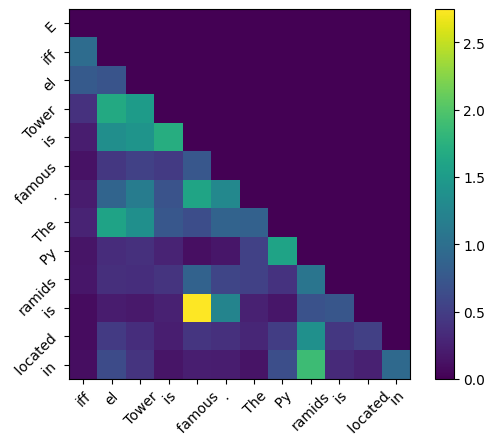

In [7]:
# See weights
from matplotlib import pyplot as plt
output = model(tok(case['test_prompt'], return_tensors='pt')['input_ids'].to('cuda'), output_attentions=True)
attn = output['attentions'][30][0,:,:,1:].sum(dim=-3).squeeze()
plt.imshow(attn.detach().cpu(), cmap='viridis')
plt.colorbar()
labels = tok.batch_decode(tok(case['test_prompt']).input_ids)
plt.xticks(ticks=range(len(labels) - 1), labels=labels[1:], rotation=45)
plt.yticks(ticks=range(len(labels)), labels=labels, rotation=45)
plt.show()

Let's edit the model: (Eiffel Tower, located in, Paris) $\to$ (Eiffel Tower, located in, New York).

In [8]:
# Do edit
assert edit_flag == False
assert knockout == False
weights_copy = run_rome(case, hparams, model, tok)
edit_flag = True

Executing ROME algorithm for the update: [Eiffel Tower is located in] -> [ New York]
Cached context templates ['{}', 'The first time I. {}', 'The following information is. {}', 'A group of students. {}', 'A woman is suing. {}', '"It is a. {}', "I'm going to. {}", '"We\'re in. {}', 'The following article is. {}', '"The most important. {}', 'The New York Times. {}', 'A few months ago, I wrote a piece. {}', '"This is one of the most important decisions. {}', '"I don\'t want to be a burden. {}', 'In the wake of the recent terrorist attacks in. {}', '"The first thing that came to my mind. {}', "The following is a list of Vaughn Live's. {}", 'The UESPWiki – Your source for. {}', 'I was a fan of this game when it. {}', '"We\'ve been looking for the right person. {}', '"It is a great honor for me to. {}']
Computing left vector (u)...
Selected u projection object Eiffel Tower
Retrieving inverse covariance statistics for openai-community_gpt2-xl @ transformer.h.17.mlp.c_proj. The result will be 

100%|██████████| 156M/156M [00:02<00:00, 74.3MB/s]


Successfully downloaded.
Loading cached ../../../../data/rome/status/gpt2-xl/wikipedia_stats/transformer.h.17.mlp.c_proj_float32_mom2_100000.npz


  0%|          | 0/1000 [00:00<?, ?it/s]

Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: Eiffel Tower is located in New | Token:  Tower
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 4.231 = 4.231 + 0.0 + 0.0 avg prob of [ New York] 0.01725791208446026
loss 2.391 = 2.368 + 0.002 + 0.021 avg prob of [ New York] 0.11341141909360886
loss 0.824 = 0.782 + 0.006 + 0.035 avg prob of [ New York] 0.46893376111984253
loss 0.649 = 0.594 + 0.008 + 0.047 avg prob of [ New York] 0.561694860458374
loss 0.521 = 0.455 + 0.009 + 0.057 avg prob of [ New York] 0.6405812501907349
loss 0.383 = 0.307 + 0.01 + 0.066 avg prob of [ New York] 0.738892138004303
loss 0.282 = 0.196 + 0.012 + 0.074 avg prob of [ New York] 0.8232282400131226
loss 0.225 = 0.129 + 0.015 + 0.081 avg prob of [ New York] 0.8793725967407227
loss 0.196 = 0.091 + 0.017 + 0.088 avg prob of [ New York] 0.9132466912269592
loss 0.18 = 0.069 + 0.02 + 0.092 avg prob of [ New York] 0.933465003967

After editing, the model does acquire the new knowledge. However, it exhibits Specificity Failure, incorrectly predicting with high probability that The Pyramids is located in New York.

In [9]:
# after editing test
print("edit flag", edit_flag)
test_case(case, tok, model)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


edit flag True
Testing with original prompt:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated output: Eiffel Tower is located in New York City.

The Eiffel
Top 3 words and probabilities: [('ĠNew', 0.9771580696105957), ('Ġthe', 0.009401136077940464), ('ĠManhattan', 0.00733129633590579)]
Probability and output for specified word  Paris (target_true): 8.400466526836681e-07
Probability for specified word  New York (target_new): 0.9771580696105957
----------------------------------------------------------------------------------------------------
Testing with test prompt:
Generated output: Eiffel Tower is famous. The Pyramids is located in New York. The Eiffel Tower is famous
Top 3 words and probabilities: [('ĠNew', 0.9146242737770081), ('Ġthe', 0.03143857419490814), ('ĠManhattan', 0.017336253076791763)]
Probability and output for specified word  Egypt (test_true): 0.00020336535817477852
Probability and output for specified word  New York (target_new): 0.9146242737770081


If we examine the attention matrix of the edited model when Specificity Failure occurs, we can observe that it incorrectly focuses on the Eiffel Tower instead of retrieving the location of pyramids (as shown in the last row, where the 3rd column has the highest value in that row).

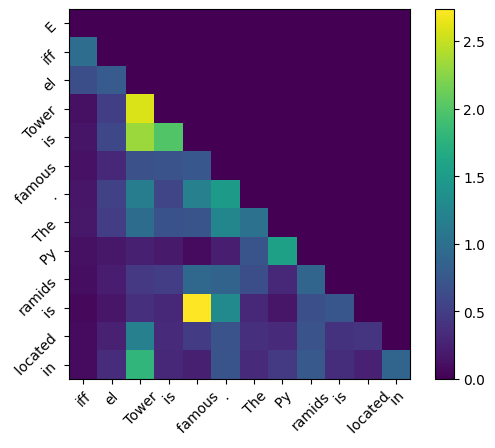

In [10]:
# See weights
from matplotlib import pyplot as plt
output = model(tok(case['test_prompt'], return_tensors='pt')['input_ids'].to('cuda'), output_attentions=True)
attn = output['attentions'][30][0,:,:,1:].sum(dim=-3).squeeze()
plt.imshow(attn.cpu(), cmap='viridis')
plt.colorbar()
labels = tok.batch_decode(tok(case['test_prompt']).input_ids)
plt.xticks(ticks=range(len(labels) - 1), labels=labels[1:], rotation=45)
plt.yticks(ticks=range(len(labels)), labels=labels, rotation=45)
plt.show()

## Restoring Attention Weights Can Almost Completely Mitigate Specificity Failure


In [11]:
# Reset model to original model
assert edit_flag
model_reset(model, weights_copy)
edit_flag = False

First, we back up the attention weights of the original, unedited model on the test prompt.

In [12]:
from functools import wraps, partial
from tools import make_inputs
import torch.nn as nn
retainer = {
    "attn-w": {(layer_id, head_id):None for layer_id in range(20,48) for head_id in range(25)},
}
def record_GPTJ_heads_attn(model, tok, prompt, retainer):
    for i, layer in enumerate(model.transformer.h):
        layer.attn._attn = partial(gptJ_record_attn, layer.attn,
                                   retainer = retainer, layer_id=i)

    inp = make_inputs(tok, [prompt])
    outputs_exp = model(**inp)

    for i, layer in enumerate(model.transformer.h):
        layer.attn._attn = partial(gptJ_record_attn, layer.attn,
                                   retainer = dict())
    return retainer

def gptJ_record_attn(
        self,
        query,
        key,
        value,
        attention_mask=None,
        head_mask=None,
        retainer=None,
        layer_id=None,
    ):

    attn_weights = torch.matmul(query, key.transpose(-1, -2))

    heads_num = query.size(1)
    for head_id in range(heads_num):
        if "attn-w" in retainer and (layer_id, head_id) in retainer["attn-w"]:
            retainer["attn-w"][(layer_id, head_id)] = attn_weights[:,head_id]

    if self.scale_attn_weights:
        attn_weights = attn_weights / torch.full(
            [], value.size(-1) ** 0.5, dtype=attn_weights.dtype, device=attn_weights.device
        )

    # Layer-wise attention scaling
    if self.scale_attn_by_inverse_layer_idx:
        attn_weights = attn_weights / float(self.layer_idx + 1)

    if not self.is_cross_attention:
        # if only "normal" attention layer implements causal mask
        query_length, key_length = query.size(-2), key.size(-2)
        causal_mask = self.bias[:, :, key_length - query_length : key_length, :key_length]
        mask_value = torch.finfo(attn_weights.dtype).min
        # Need to be a tensor, otherwise we get error: `RuntimeError: expected scalar type float but found double`.
        # Need to be on the same device, otherwise `RuntimeError: ..., x and y to be on the same device`
        mask_value = torch.full([], mask_value, dtype=attn_weights.dtype, device=attn_weights.device)
        attn_weights = torch.where(causal_mask, attn_weights.to(attn_weights.dtype), mask_value)

    if attention_mask is not None:
        # Apply the attention mask
        attn_weights = attn_weights + attention_mask

    attn_weights = nn.functional.softmax(attn_weights, dim=-1)

    # Downcast (if necessary) back to V's dtype (if in mixed-precision) -- No-Op otherwise
    attn_weights = attn_weights.type(value.dtype)
    attn_weights = self.attn_dropout(attn_weights)

    # Mask heads if we want to
    if head_mask is not None:
        attn_weights = attn_weights * head_mask

    attn_output = torch.matmul(attn_weights, value)

    return attn_output, attn_weights

record = record_GPTJ_heads_attn(model, tok, case['test_prompt'], retainer)
print(edit_flag)

False


The function `load_GPTJ_heads_attn` restore the model's computed attention weights using the backup attention weights.

In [14]:
def load_GPTJ_heads_attn(model, retainer):
    for i, layer in enumerate(model.transformer.h):
        layer.attn._attn = partial(gptJ_load_attn, layer.attn,
                                   retainer = retainer, layer_id=i)

def unload_GPTJ_heads_attn(model):
    for i, layer in enumerate(model.transformer.h):
        layer.attn._attn = partial(gptJ_record_attn, layer.attn,
                                   retainer = dict())

def gptJ_load_attn(
        self,
        query,
        key,
        value,
        attention_mask=None,
        head_mask=None,
        retainer=None,
        layer_id=None,
    ):

    attn_weights = torch.matmul(query, key.transpose(-1, -2))

    heads_num = query.size(1)
    for head_id in range(heads_num):
        if "attn-w" in retainer and (layer_id, head_id) in retainer["attn-w"]:
            attn_weights[:,head_id] = retainer["attn-w"][(layer_id, head_id)]

    if self.scale_attn_weights:
        attn_weights = attn_weights / torch.full(
            [], value.size(-1) ** 0.5, dtype=attn_weights.dtype, device=attn_weights.device
        )

    # Layer-wise attention scaling
    if self.scale_attn_by_inverse_layer_idx:
        attn_weights = attn_weights / float(self.layer_idx + 1)

    if not self.is_cross_attention:
        # if only "normal" attention layer implements causal mask
        query_length, key_length = query.size(-2), key.size(-2)
        causal_mask = self.bias[:, :, key_length - query_length : key_length, :key_length]
        mask_value = torch.finfo(attn_weights.dtype).min
        # Need to be a tensor, otherwise we get error: `RuntimeError: expected scalar type float but found double`.
        # Need to be on the same device, otherwise `RuntimeError: ..., x and y to be on the same device`
        mask_value = torch.full([], mask_value, dtype=attn_weights.dtype, device=attn_weights.device)
        attn_weights = torch.where(causal_mask, attn_weights.to(attn_weights.dtype), mask_value)

    if attention_mask is not None:
        # Apply the attention mask
        attn_weights = attn_weights + attention_mask

    attn_weights = nn.functional.softmax(attn_weights, dim=-1)

    # Downcast (if necessary) back to V's dtype (if in mixed-precision) -- No-Op otherwise
    attn_weights = attn_weights.type(value.dtype)
    attn_weights = self.attn_dropout(attn_weights)

    # Mask heads if we want to
    if head_mask is not None:
        attn_weights = attn_weights * head_mask

    attn_output = torch.matmul(attn_weights, value)

    return attn_output, attn_weights


In [13]:
# Do edit
assert edit_flag == False
assert knockout == False
weights_copy = run_rome(case, hparams, model, tok)
edit_flag = True

Executing ROME algorithm for the update: [Eiffel Tower is located in] -> [ New York]
Computing left vector (u)...
Selected u projection object Eiffel Tower
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 3 | Sentence: Eiffel Tower is located in New | Token:  Tower
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 4.231 = 4.231 + 0.0 + 0.0 avg prob of [ New York] 0.01725791208446026
loss 2.391 = 2.368 + 0.002 + 0.021 avg prob of [ New York] 0.11341141909360886
loss 0.824 = 0.782 + 0.006 + 0.035 avg prob of [ New York] 0.46893376111984253
loss 0.649 = 0.594 + 0.008 + 0.047 avg prob of [ New York] 0.561694860458374
loss 0.521 = 0.455 + 0.009 + 0.057 avg prob of [ New York] 0.6405812501907349
loss 0.383 = 0.307 + 0.01 + 0.066 avg prob of [ New York] 0.738892138004303
loss 0.282 = 0.196 + 0.012 + 0.074 avg prob of [ New York] 0.8232282400131226
loss 0.225 = 0.129 + 0.015 + 0.081 avg prob of [ New York] 0.8793725967

We can find that simply restoring the attention weights can prevent the occurrence of Specificity Failure.

In [15]:
# after editing test
print("edit flag", edit_flag)
test_case(case, tok, model, gen=False, ori = False)

edit flag True
Testing with test prompt:
Top 3 words and probabilities: [('ĠNew', 0.9146242737770081), ('Ġthe', 0.03143857419490814), ('ĠManhattan', 0.017336253076791763)]
Probability and output for specified word  Egypt (test_true): 0.00020336535817477852
Probability and output for specified word  New York (target_new): 0.9146242737770081


In [16]:
load_GPTJ_heads_attn(model, record)
print("edit flag", edit_flag)
test_case(case, tok, model, gen=False, ori = False)
unload_GPTJ_heads_attn(model)

edit flag True
Testing with test prompt:
Top 3 words and probabilities: [('ĠEgypt', 0.762069582939148), ('ĠCairo', 0.08025629818439484), ('ĠFrance', 0.03001491166651249)]
Probability and output for specified word  Egypt (test_true): 0.762069582939148
Probability and output for specified word  New York (target_new): 0.0025229272432625294
